In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import numpy as np

import cartopy.crs as ccrs
import cartopy as cart
import cmocean
import torch
import torch.nn as nn
import torch.utils.data as data
import torch_geometric
from torch.nn import Sequential as Seq, Linear, ReLU
from Networks import *
from Data_Functions import *
from matplotlib.animation import FuncAnimation
from Utils import *
from Subgrid_Funcs import *
from Eval_Funcs import *
from Parallel import *
import numpy.fft as fft
import sys
import matplotlib.ticker as ticker


In [ ]:
exp_num_in = "3"
exp_num_extra = "5"
exp_num_out = "2"


mse = torch.nn.MSELoss()

region = "Tropics_Ext"   
network = "U_net"

interval = 2

N_samples = 2000
N_val = 100
N_test = 1000

Nb = 4

factor = 10

hist = 0

lag = 1

steps = 1

if len(sys.argv) > 4:
    n_cond = int((len(sys.argv)-4)/2)

str_video = ""

try:
    for i in range(n_cond):
        if type(globals()[sys.argv[int(4 + i*2)]]) == str:
            temp = str(sys.argv[int(5 + i*2)])
            exec(sys.argv[int(4 + i*2)] +"= temp" )
            if sys.argv[int(4 + i*2)] == "network":
                continue
            str_video += "_" + sys.argv[int(4 + i*2)] + "_" + sys.argv[int(5 + i*2)]
        elif type(globals()[sys.argv[int(4 + i*2)]]) == int:
            exec(sys.argv[int(4 + i*2)] +"=" + "int(" + sys.argv[int(5 + i*2)] +")" )
            str_video += "_" + sys.argv[int(4 + i*2)] + "_" + sys.argv[int(5 + i*2)]
    print(str_video)
except:
    print("no cond")

    
if region == "Kuroshio":
    lat = [15,41]
    lon = [-215, -185]
elif region == "Kuroshio_Ext":
    lat = [5,50]
    lon = [-250, -175]      
elif region == "Gulf_Stream":
    lat = [25, 50]
    lon = [-70,-35]
elif region == "Gulf_Stream_Ext":
    lat = [27, 50]
    lon = [-82,-35]       
elif region == "Tropics":
    lat = [-5,25]
    lon = [-95,-65]  
elif region == "Tropics_Ext":
    lat = [-5,25]
    lon = [-115,-45]     
elif region == "South_America":
    lat = [-60, -30]
    lon = [-70,-35] 
elif region == "Africa":
    lat = [-50, -20]
    lon = [5,45] 
elif region == "Quiescent":
    lat = [-42.5, -17.5]
    lon = [-155,-120] 
elif region == "Quiescent_Ext":
    lat = [-55, -10]
    lon = [-170,-110]            
elif region == "Pacific":
    lat = [-35, 35]
    lon = [-230,-80]     
elif region == "Indian":
    lat = [-30, 28]
    lon = [30,79]   
elif region == "Africa_Ext":
    lat = [-55, -15]
    lon = [-5,55]        
        
s_train = lag*hist
e_train = s_train + N_samples*interval
e_test = e_train + interval*N_val



device = "cpu"


inpt_dict = {"1":["um","vm"],"2":["um","vm","ur","vr"],"3":["um","vm","Tm"],
            "4":["um","vm","ur","vr","Tm","Tr"],"5":["ur","vr"],"6":["ur","vr","Tr"],
            "7":["Tm"],"8":["Tm","Tr"],"9":["u","v"],"10":["u","v","T"],
            "11":["tau_u","tau_v"]} 
extra_dict = {"1":["ur","vr"],"2":["ur","vr","Tm"],
            "3":["Tm"],"4":["ur","vr","Tm","Tr"],"5":[],"6":["um","vm"],
             "7":["um","vm","Tm"], "8": ["um","vm","Tm","Tr"],
              "9":["ur","vr","tau_u","tau_v"],"10":["tau_u","tau_v"],
              "11":["t_ref"],"12":["tau_u","tau_v","t_ref"]} 
out_dict = {"1":["um","vm"],"2":["um","vm","Tm"],"3":["ur","vr"],
           "4":["ur","vr","Tr"],"5":["u","v"],"6":["u","v","T"]}


grids = xr.open_dataset('/scratch/zanna/data/CM2_grids/Grid_cm25_Vertices.nc')
if "global" in region:
    grids = coarse_grid(grids,factor)

else:
    grids = grids.sel({"yu_ocean":slice(lat[0],lat[1]),"xu_ocean":slice(lon[0],lon[1])})


area = torch.from_numpy(grids["area_C"].to_numpy()).to(device=device)
dx = grids["dxu"].to_numpy()
dy = grids["dyu"].to_numpy()



inputs = inpt_dict[exp_num_in]
extra_in = extra_dict[exp_num_extra]
outputs = out_dict[exp_num_out]

str_in = "".join([i + "_" for i in inputs])
str_ext = "".join([i + "_" for i in extra_in])
str_out = "".join([i + "_" for i in outputs])

print("inputs: " + str_in)
print("extra inputs: " + str_ext)
print("outputs: " + str_out)

N_atm = len(extra_in)
N_in = len(inputs)
N_extra = N_atm + N_in
N_out = len(outputs)

num_in = int((hist+1)*N_in + N_extra)

if "global" in region:
    inputs, extra_in, outputs = gen_data_global(inputs,extra_in,outputs,lag)
else:
    inputs, extra_in, outputs = inputs, extra_in, outputs = gen_data_025_lateral(inputs,extra_in,outputs,lag,lat,lon,Nb,filter_T = True)


wet = xr.zeros_like(inputs[0][0])
# inputs[0][0,12,12] = np.nan
for data in inputs:
    wet +=np.isnan(data[0])
wet_nan = xr.where(wet!=0,np.nan,1).to_numpy()
wet = xr.where(wet==0,np.nan,0)    
wet = np.isnan(wet)
wet = np.nan_to_num(wet.to_numpy())
wet = torch.from_numpy(wet).type(torch.float32).to(device=device)
wet_bool = np.array(wet.cpu()).astype(bool)

time_vec = inputs[0].time.data

no cond
inputs: um_vm_Tm_
extra inputs: 
outputs: um_vm_Tm_


In [ ]:
data_in_test = gen_data_in_test(0,e_test,N_test,lag,hist,inputs,extra_in)

data_out_test = gen_data_out_test(0,e_test,N_test,lag,hist,outputs)

test_data = data_CNN_Lateral(data_in_test,data_out_test,wet.to(device = "cpu"),N_atm,Nb,device="cpu") 

time_test = time_vec[e_test:(e_test+lag*N_test)]

mean_out = test_data.norm_vals['m_out']  
std_out = test_data.norm_vals['s_out']  
mean_in = test_data.norm_vals['m_in']  
std_in = test_data.norm_vals['s_in']  

In [4]:
def get_stats(region,step,rand_int,str_in,str_ext,test_data,area,wet_bool,N_mean,lag,lam):
    extra_dict = {"5":[],"10":["tau_u","tau_v"],
                  "11":["t_ref"],"12":["tau_u","tau_v","t_ref"]}     
    str_ext = "".join([i + "_" for i in extra_dict[lam]])


    model_pred_atm = xr.open_zarr("/scratch/as15415/Emulation/Preds/Pred_lateral_Fast_Data_025_"+region+"_in_"+str_in+"ext_"+str_ext+"N_samples_"+str(4000)+"_rand_seed_"+str(rand_int)+".zarr").sel(time=slice(0,N_mean)).to_array().to_numpy().squeeze()

#     model_pred_atm = xr.open_zarr("/scratch/as15415/Emulation/Preds/Pred_lateral_Fast_Data_masked_025_"+region+"_in_"+str_in+"ext_"+str_ext+"lam_"+str(100)+"_rand_seed_"+str(rand_int)+".zarr").sel(time=slice(0,N_mean)).to_array().to_numpy().squeeze()

#     model_pred_atm = xr.open_zarr("/scratch/as15415/Emulation/Preds/Pred_"+region+"_N_Samples_1500.zarr").sel(time=slice(0,N_mean)).to_array().to_numpy().squeeze()
    mean_atm, auto_mean = compute_mean(N_mean,test_data,model_pred_atm,area.cpu(),wet_bool)
    var_atm, auto_var = compute_var(N_mean,test_data,model_pred_atm,area.cpu(),wet_bool)    
    rmse_atm, auto_rmse = compute_rmse(np.min((500,N_mean)),test_data,model_pred_atm,area.cpu(),wet_bool)
    corrs_atm, auto_corrs = compute_corrs(np.min((500,N_mean)),test_data,model_pred_atm,wet_bool)
    KE, auto_KE = compute_KE(N_mean,test_data,model_pred_atm,area,wet_bool)
    freqs,FFT,auto_FFT = compute_time_spec(N_mean,auto_mean,mean_atm,lag)

    return model_pred_atm, mean_atm, auto_mean, rmse_atm, auto_rmse, corrs_atm, auto_corrs, KE, auto_KE, freqs, FFT, auto_FFT, var_atm, auto_var

In [5]:
def get_spred(region,step,num_IC,str_in,str_ext,test_data,area,wet_bool,N_mean,lag,lam):
    mean = np.zeros((num_IC,N_mean,3))
    var = np.zeros((num_IC,N_mean,3))    
    KE = np.zeros((num_IC,N_mean))    
    rmse = np.zeros((num_IC,np.min((500,N_mean)),3))
    corrs = np.zeros((num_IC,np.min((500,N_mean)),3))
    FFTs = np.zeros((num_IC,int(N_mean/2+1),3))
    
    for i in range(0,num_IC):
        out, mean_1, out, rmse_1, out, corrs_1, out, KE_1, out, freqs, FFT_1, out, var_1, out = get_stats(region,step,i+1,str_in,str_ext,test_data,area,wet_bool,N_mean,lag,lam)
        KE[i] = KE_1
        mean[i] = mean_1
        rmse[i] = rmse_1
        corrs[i] = corrs_1
        FFTs[i] = FFT_1    
        var[i] = var_1
    return mean, rmse, corrs, KE, FFTs, freqs, var


In [32]:
mean_5, rmse_5, corrs_5,KE_5,FFTs_5,freqs,var_5 = get_spred(region,4,3,str_in,str_ext,test_data,area,wet_bool,3000,lag,"5")
mean_10, rmse_10, corrs_10,KE_10,FFTs_10,freqs,var_10 = get_spred(region,4,3,str_in,str_ext,test_data,area,wet_bool,3000,lag,"10")
mean_11, rmse_11, corrs_11,KE_11,FFTs_11,freqs,var_11 = get_spred(region,4,3,str_in,str_ext,test_data,area,wet_bool,3000,lag,"11")
mean_12, rmse_12, corrs_12,KE_12,FFTs_12,freqs,var_12 = get_spred(region,4,3,str_in,str_ext,test_data,area,wet_bool,3000,lag,"12")


In [33]:
model_pred_1, m, auto_mean, r, auto_rmse, c, auto_corrs, K, auto_KE, freqs, F, auto_FFT, v, auto_var = get_stats(region,4,1,str_in,str_ext,test_data,area,wet_bool,3000,lag,"12")
# model_pred_2, m, auto_mean, r, auto_rmse, c, auto_corrs, K, auto_KE, freqs, F, auto_FFT, v, auto_var = get_stats(region,4,2,str_in,str_ext,test_data,area,wet_bool,3000,lag,"12")
# model_pred_3, m, auto_mean, r, auto_rmse, c, auto_corrs, K, auto_KE, freqs, F, auto_FFT, v, auto_var = get_stats(region,4,3,str_in,str_ext,test_data,area,wet_bool,3000,lag,"12")

In [8]:
N = 5

plt.style.use('bmh')

clist_1 = [cmocean.cm.thermal(i/(N-.5)) for i in range(1,N)]
clist_2 = ['#d7191c','#abd9e9','#2c7bb6','#fdae61']
clist_3 = ["#91B59A","#D6A922","#1E88E5","#A00B41"]
clist = clist_3

/state/partition1/job-42511553/ipykernel_2672067/1564744747.py:38: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axs[plt_index].set_xlim([0,freqs[T_plot]])


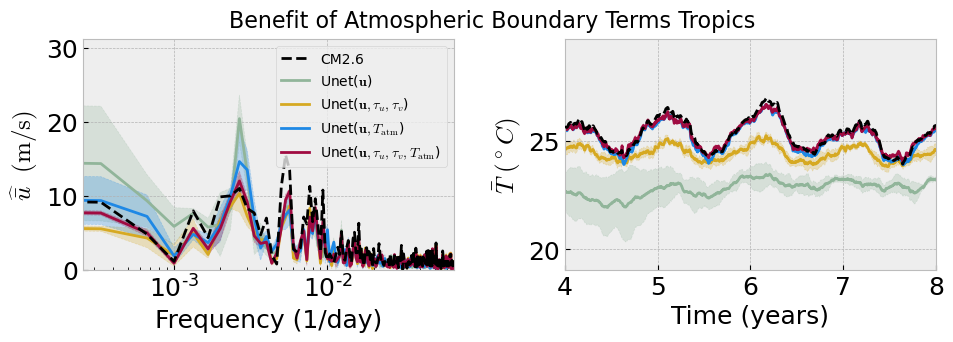

In [34]:
# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('figure', titlesize=18)


fig, axs = plt.subplots(1, 2, figsize=(11,3),
                        gridspec_kw={'width_ratios': [1,1], 'height_ratios': [1], 'wspace': 0.3,'hspace':.5})
plot_time_spec(0,0,True)
plot_mean(1,2)


region_title = ""

for i in region:
    if region == "Quiescent_Ext":
        region_title = "South Pacific"
    elif region == "Africa_Ext":
        region_title = "African Cape"         
    elif i == "_":
        region_title += " "
    elif i == "E":
        break
    else:
        region_title+= i
region_title = str(region_title)

fig.suptitle('Benefit of Atmospheric Boundary Terms ' +region_title, fontsize=16)

plt.savefig("/scratch/as15415/Emulation/Figures/Boundary_Figure_Paper_"+region+".png",bbox_inches='tight')

In [29]:
def plot_time_spec(plt_index,index,legend=True):
    T_plot = 200

    N_int = int(T_plot)
    N_true = min(N_test,N_int)

    var_list = {"1":r"$\widehat{\bar{v}} ~~\mathrm{(m/s)}$","0":r"$\widehat{\bar{u}} ~~\mathrm{(m/s)}$","2":r"$\widehat{\bar{T}} ~ (^\circ C)$"}



    axs[plt_index].semilogx(freqs[:N_int],auto_FFT[:N_int,index],"--k",label = "CM2.6",zorder=5)



    axs[plt_index].plot(freqs[:N_int],FFTs_5.mean(axis=0)[:N_int,index],color=clist[0],label=r"Unet($\mathbf{u}$)")
    axs[plt_index].fill_between(freqs[:N_int],FFTs_5.mean(axis=0)[:N_int,index]-FFTs_5.std(axis=0)[:N_int,index],
                     FFTs_5.mean(axis=0)[:N_int,index]+FFTs_5.std(axis=0)[:N_int,index],
                     ls="--",color=clist[0],alpha=.25)

    axs[plt_index].plot(freqs[:N_int],FFTs_10.mean(axis=0)[:N_int,index],color=clist[1],label=r"Unet($\mathbf{u},\tau_u,\tau_v$)")
    axs[plt_index].fill_between(freqs[:N_int],FFTs_10.mean(axis=0)[:N_int,index]-FFTs_10.std(axis=0)[:N_int,index],
                     FFTs_10.mean(axis=0)[:N_int,index]+FFTs_10.std(axis=0)[:N_int,index],
                     ls="--",color=clist[1],alpha=.25)

    axs[plt_index].plot(freqs[:N_int],FFTs_11.mean(axis=0)[:N_int,index],color=clist[2],label=r"Unet($\mathbf{u},T_{\mathrm{atm}}$)")
    axs[plt_index].fill_between(freqs[:N_int],FFTs_11.mean(axis=0)[:N_int,index]-FFTs_11.std(axis=0)[:N_int,index],
                     FFTs_11.mean(axis=0)[:N_int,index]+FFTs_11.std(axis=0)[:N_int,index],
                     ls="--",color=clist[2],alpha=.25)

    axs[plt_index].plot(freqs[:N_int],FFTs_12.mean(axis=0)[:N_int,index],color=clist[3],label=r"Unet($\mathbf{u},\tau_u,\tau_v,T_{\mathrm{atm}}$)")
    axs[plt_index].fill_between(freqs[:N_int],FFTs_12.mean(axis=0)[:N_int,index]-FFTs_12.std(axis=0)[:N_int,index],
                     FFTs_12.mean(axis=0)[:N_int,index]+FFTs_12.std(axis=0)[:N_int,index],
                     ls="--",color=clist[3],alpha=.25)

    axs[plt_index].set_ylabel(r"" +var_list[str(index)])
    axs[plt_index].set_xlabel("Frequency (1/day)")

    axs[plt_index].set_xlim([0,freqs[T_plot]])
    axs[plt_index].set_ylim([0,auto_FFT[1:N_int,index].max()*2])

    if legend:
        axs[plt_index].legend(ncol=1, loc = "upper right")



    # plt.tight_layout()


In [10]:
def plot_var(plt_index,index):
    T_plot = 1098

    N_int = int(T_plot/lag)
    N_true = min(N_test,N_int)

    var_list = {"1":r"$\mathrm{Var}(\bar{v})$","0":r"$\mathrm{Var}(\bar{u})$","2":r"$\mathrm{Var}(\bar{T})$"}


    axs[plt_index].plot((np.arange(N_int)*lag)/366,auto_var[:N_int,index],"--k",label = "CM2.6",zorder=5)


    axs[plt_index].plot((np.arange(N_int)*lag)/366,var_5.mean(axis=0)[:N_int,index],color=clist[0],label=r"Unet($\mathbf{u}$)")
    axs[plt_index].fill_between((np.arange(N_int)*lag)/366,var_5.mean(axis=0)[:N_int,index]-var_5.std(axis=0)[:N_int,index],
                     var_5.mean(axis=0)[:N_int,index]+var_5.std(axis=0)[:N_int,index],
                     ls="--",color=clist[0],alpha=.25)


    axs[plt_index].plot((np.arange(N_int)*lag)/366,var_10.mean(axis=0)[:N_int,index],color=clist[1],label=r"Unet($\mathbf{u},\tau_u,\tau_v$)")
    axs[plt_index].fill_between((np.arange(N_int)*lag)/366,var_10.mean(axis=0)[:N_int,index]-var_10.std(axis=0)[:N_int,index],
                     var_10.mean(axis=0)[:N_int,index]+var_10.std(axis=0)[:N_int,index],
                     ls="--",color=clist[1],alpha=.25)

    axs[plt_index].plot((np.arange(N_int)*lag)/366,var_11.mean(axis=0)[:N_int,index],color=clist[2],label=r"Unet($\mathbf{u},T_{ref}$)")
    axs[plt_index].fill_between((np.arange(N_int)*lag)/366,var_11.mean(axis=0)[:N_int,index]-var_11.std(axis=0)[:N_int,index],
                     var_11.mean(axis=0)[:N_int,index]+var_11.std(axis=0)[:N_int,index],
                     ls="--",color=clist[2],alpha=.25)

    axs[plt_index].plot((np.arange(N_int)*lag)/366,var_12.mean(axis=0)[:N_int,index],color=clist[3],label=r"Unet($\mathbf{u},\tau_u,\tau_v,T_{ref}$)")
    axs[plt_index].fill_between((np.arange(N_int)*lag)/366,var_12.mean(axis=0)[:N_int,index]-var_12.std(axis=0)[:N_int,index],
                     var_12.mean(axis=0)[:N_int,index]+var_12.std(axis=0)[:N_int,index],
                     ls="--",color=clist[3],alpha=.25)


    axs[plt_index].set_ylabel(r"" +var_list[str(index)])
    axs[plt_index].set_xlabel("Time (years)")

    axs[plt_index].set_xlim([0,T_plot/366])
    axs[plt_index].yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True, useOffset=False))
    axs[plt_index].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    axs[plt_index].xaxis.set_major_locator(ticker.MultipleLocator(base=0.5))  # Adjust base as needed

#     axs[plt_index].legend(ncol=2)




In [28]:
def plot_mean(plt_index,index):

    T_plot = 3000

    N_int = int(T_plot/lag)
    N_true = min(N_test,N_int)

    var_list = {"1":r"$\bar{v}~~\mathrm{(m/s)}$","0":r"$\bar{u}~~\mathrm{(m/s)}$","2":r"$\bar{T} ~ (^\circ C)$"}


    axs[plt_index].plot((np.arange(N_int)*lag)/366,auto_mean[:N_int,index],"--k",label = "CM2.6",zorder=5)


    axs[plt_index].plot((np.arange(N_int)*lag)/366,mean_5.mean(axis=0)[:N_int,index],color=clist[0],label=r"Unet($\mathbf{u}$)")
    axs[plt_index].fill_between((np.arange(N_int)*lag)/366,mean_5.mean(axis=0)[:N_int,index]-mean_5.std(axis=0)[:N_int,index],
                     mean_5.mean(axis=0)[:N_int,index]+mean_5.std(axis=0)[:N_int,index],
                     ls="--",color=clist[0],alpha=.25)


    axs[plt_index].plot((np.arange(N_int)*lag)/366,mean_10.mean(axis=0)[:N_int,index],color=clist[1],label=r"Unet($\mathbf{u},\tau_u,\tau_v$)")
    axs[plt_index].fill_between((np.arange(N_int)*lag)/366,mean_10.mean(axis=0)[:N_int,index]-mean_10.std(axis=0)[:N_int,index],
                     mean_10.mean(axis=0)[:N_int,index]+mean_10.std(axis=0)[:N_int,index],
                     ls="--",color=clist[1],alpha=.25)

    axs[plt_index].plot((np.arange(N_int)*lag)/366,mean_11.mean(axis=0)[:N_int,index],color=clist[2],label=r"Unet($\mathbf{u},T_{ref}$)")
    axs[plt_index].fill_between((np.arange(N_int)*lag)/366,mean_11.mean(axis=0)[:N_int,index]-mean_11.std(axis=0)[:N_int,index],
                     mean_11.mean(axis=0)[:N_int,index]+mean_11.std(axis=0)[:N_int,index],
                     ls="--",color=clist[2],alpha=.25)

    axs[plt_index].plot((np.arange(N_int)*lag)/366,mean_12.mean(axis=0)[:N_int,index],color=clist[3],label=r"Unet($\mathbf{u},\tau_u,\tau_v,T_{ref}$)")
    axs[plt_index].fill_between((np.arange(N_int)*lag)/366,mean_12.mean(axis=0)[:N_int,index]-mean_12.std(axis=0)[:N_int,index],
                     mean_12.mean(axis=0)[:N_int,index]+mean_12.std(axis=0)[:N_int,index],
                     ls="--",color=clist[3],alpha=.25)


    axs[plt_index].set_ylabel(r"" +var_list[str(index)])
    axs[plt_index].set_xlabel("Time (years)")

    min_val = auto_mean[:N_int,index].min()
    max_val = auto_mean[:N_int,index].max()

    
    if min_val > 0:
        axs[plt_index].set_ylim([min_val*.8,max_val*1.1])
    elif min_val<0 and max_val>0:
        axs[plt_index].set_ylim([min_val*1.1,max_val*1.1])
    else:
        axs[plt_index].set_ylim([min_val*1.1,0])


    if index == 2:
        axs[plt_index].set_xlim([4,8])
        axs[plt_index].xaxis.set_major_locator(ticker.MultipleLocator(base=1))  # Adjust base as needed

    #     axs[plt_index].set_ylim([22,28])
    else:
        axs[plt_index].set_xlim([7,8])
        axs[plt_index].yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True, useOffset=False))
        axs[plt_index].ticklabel_format(axis='y', style='sci', scilimits=(0,0))    
        axs[plt_index].xaxis.set_major_locator(ticker.MultipleLocator(base=0.5))  # Adjust base as needed
   
       

In [ ]:
# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('figure', titlesize=18)


fig, axs = plt.subplots(2, 2, figsize=(11,6),
                        gridspec_kw={'width_ratios': [1,1], 'height_ratios': [1,1], 'wspace': 0.3,'hspace':.5})
plot_time_spec((0,0),0,False)
plot_mean((0,1),0)
plot_time_spec((1,0),1)
plot_mean((1,1),2)

region_title = ""

for i in region:
    if region == "Quiescent_Ext":
        region_title = "South Pacific"
    elif region == "Africa_Ext":
        region_title = "African Cape"         
    elif i == "_":
        region_title += " "
    elif i == "E":
        break
    else:
        region_title+= i
region_title = str(region_title)

fig.suptitle('Long-Time Statistics ' +region_title, fontsize=16)

plt.savefig("/scratch/as15415/Emulation/Figures/Long_Time_Comp_Boundary_"+region+".png",bbox_inches='tight')